In [35]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [71]:
from datetime import datetime, timedelta

In [72]:
sns.set_theme(style='darkgrid')

In [318]:
df = pd.read_csv('./coffee-consumption.csv')

In [319]:
def get_rows_cols(df):
    return df.shape[0], df.shape[1]

In [320]:
rows, cols = get_rows_cols(df)
print("******************************")
print("Características del dataset")
print(f"Registros: {rows}")
print(f"Campos: {cols}")
print("******************************")

******************************
Características del dataset
Registros: 1133
Campos: 6
******************************


In [48]:
print("******************************")
print("Características generales de las variables numéricas\n")
print(df.describe().T)
print("\n******************************")

******************************
Características generales de las variables numéricas

        count       mean       std    min   25%    50%    75%   max
money  1133.0  33.105808  5.035366  18.12  28.9  32.82  37.72  40.0

******************************


### Análisis de las variables numéricas

- El ticket promedio es de 33.105. No parece haber mucha dispersión en cuanto al valor medio del ticket

- El dataset ofrece la fecha de la transacción, el medio de pago (cash, card) y el tipo de café tomado por el cliente

In [49]:
print("******************************")
print("Variables y valores de nuestro dataset\n")
df.info()

******************************
Variables y valores de nuestro dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1133 entries, 0 to 1132
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         1133 non-null   object 
 1   datetime     1133 non-null   object 
 2   cash_type    1133 non-null   object 
 3   card         1044 non-null   object 
 4   money        1133 non-null   float64
 5   coffee_name  1133 non-null   object 
dtypes: float64(1), object(5)
memory usage: 53.2+ KB


### Registros duplicados

Antes de comenzar con algun gráfico, es una buena práctica tratar los datos duplicados. Esto podemos corroborarlo utilizando el método **duplicated()** de pandas que nos devolverá una matriz booleana.

Se debe tener en cuenta en este caso que la duplicidad de registros no es necesariamente mala. Un cliente puede ser habitué del lugar y consumir el mismo café todos los días y pagar con la misma tarjeta. La duplicidad de registros es mala cuando la fecha de la transacción es muy próxima en horas, minutos y segundos.

Asumiremos que hay un registro duplicado cuando los datos se repiten en un período de tiempo menor a 30 minutos.

In [322]:
def remove_duplicated_rows(df):
    time_threshold = timedelta(minutes=30) # delta de 30 minutos para evitar duplicados de transacciones
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(by='datetime').reset_index(drop=True)
    duplicates = []
    for i in range(len(df) - 1):
        for j in range(i + 1, len(df)):
            time_diff = df.loc[j, 'datetime'] - df.loc[i, 'datetime']
            if time_diff > time_threshold:
                break
            if (df.loc[i, 'cash_type'] == df.loc[j, 'cash_type']) and \
               (df.loc[i, 'card'] == df.loc[j, 'card']) and \
               (df.loc[i, 'money'] == df.loc[j, 'money']) and \
               (df.loc[i, 'coffee_name'] == df.loc[j, 'coffee_name']):
                duplicates.append(j)
    
# Eliminar duplicados (eliminar índices duplicados)
    duplicates = list(set(duplicates))
    return df.drop(duplicates).reset_index(drop=True)

In [323]:
df_without_duplicates = remove_duplicated_rows(df)

In [325]:
rows, cols = get_rows_cols(df_without_duplicates)
print("******************************")
print("Características del dataset")
print(f"Registros: {rows}")
print(f"Campos: {cols}")
print("******************************")

******************************
Características del dataset
Registros: 1031
Campos: 6
******************************


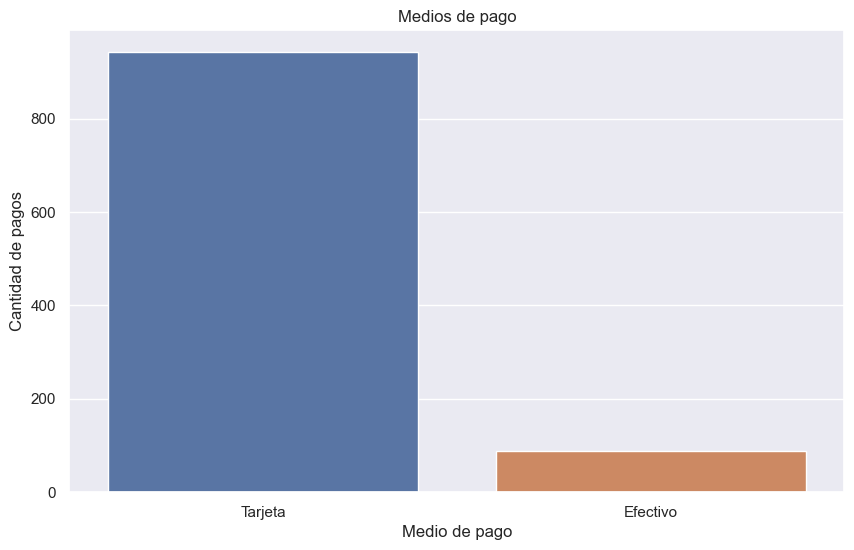

In [327]:
plt.figure(figsize = (10, 6))

sns.countplot(data=df_without_duplicates, x='cash_type')
plt.title('Medios de pago')
plt.ylabel('Cantidad de pagos')
plt.xlabel('Medio de pago')
plt.xticks(ticks=[0,1], labels=['Tarjeta', 'Efectivo'])
plt.show()

In [331]:
coffee_counts = df_without_duplicates['coffee_name'].value_counts() # devuelve un diccionario con indice y valor ordenado
ordered_coffees = coffee_counts.index # Get the index i.e Americano with Milk

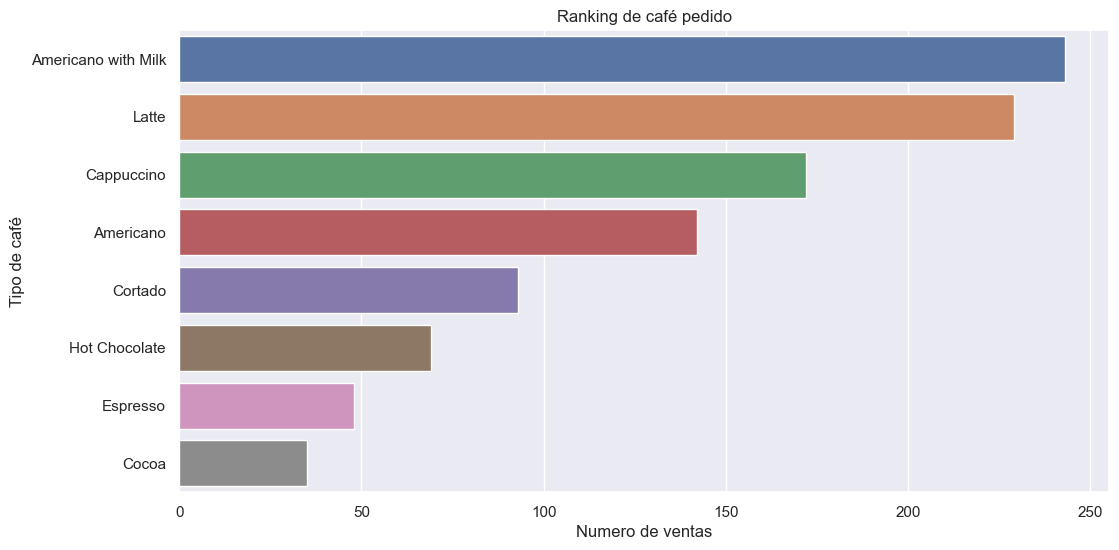

In [334]:
# Creo un un gráfico de barras ordenandolo por frecuencia de pedido
plt.figure(figsize = (12, 6))
sns.countplot(y = 'coffee_name', data = df_without_duplicates, order=ordered_coffees)
plt.title('Ranking de café pedido')
plt.xlabel('Numero de ventas')
plt.ylabel('Tipo de café')
plt.show()

### Distribución de la variable gasto

Veremos como se distribuye la variable money spent en nuestro dataset. Al principio comentamos que no había mucha variabilidad en estos datos.

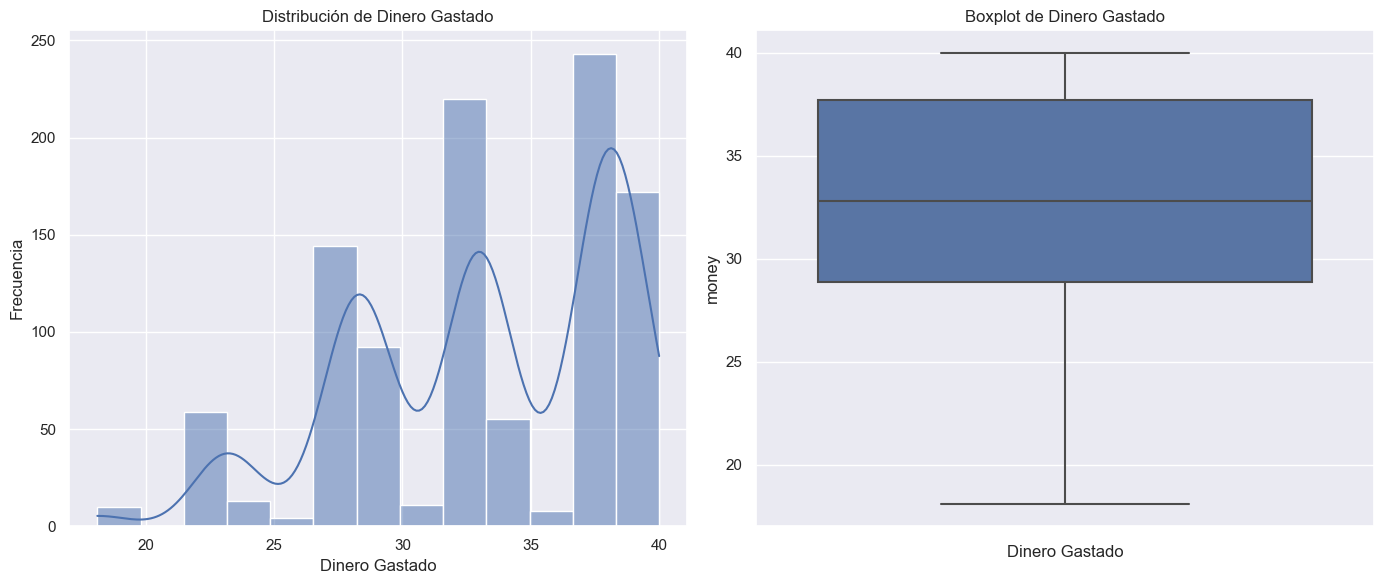

In [339]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.histplot(data=df_without_duplicates, kde=True, x='money', ax=axes[0])
axes[0].set_title('Distribución de Dinero Gastado')
axes[0].set_xlabel('Dinero Gastado')
axes[0].set_ylabel('Frecuencia')

# Diagrama de caja
sns.boxplot(data=df_without_duplicates, y='money', ax=axes[1])
axes[1].set_title('Boxplot de Dinero Gastado')
axes[1].set_xlabel('Dinero Gastado')

# Ajustar el diseño para evitar superposiciones
plt.tight_layout()

# Mostrar la figura
plt.show()

### En base a estos resultados podemos hacer dos agrupaciones.
1. Podemos agrupar por tipo de café consumido y evaluar cuál es el producto que genera más ingresos
2. Podemos crear una columna pivote que sea consumption_moment y dividir en:
    - Mañana
    - Tarde
    - Noche
    
    Y evaluar si hay alguna correlación entre el momento del día y el dinero gastado por el cliente

In [148]:
coffee_group = df_without_duplicates.groupby('coffee_name')['money'].sum().sort_values(ascending=False)
df_coffee_group = pd.DataFrame(coffee_group)
df_coffee_group = df_coffee_group.reset_index()

In [175]:
# df_coffee_group

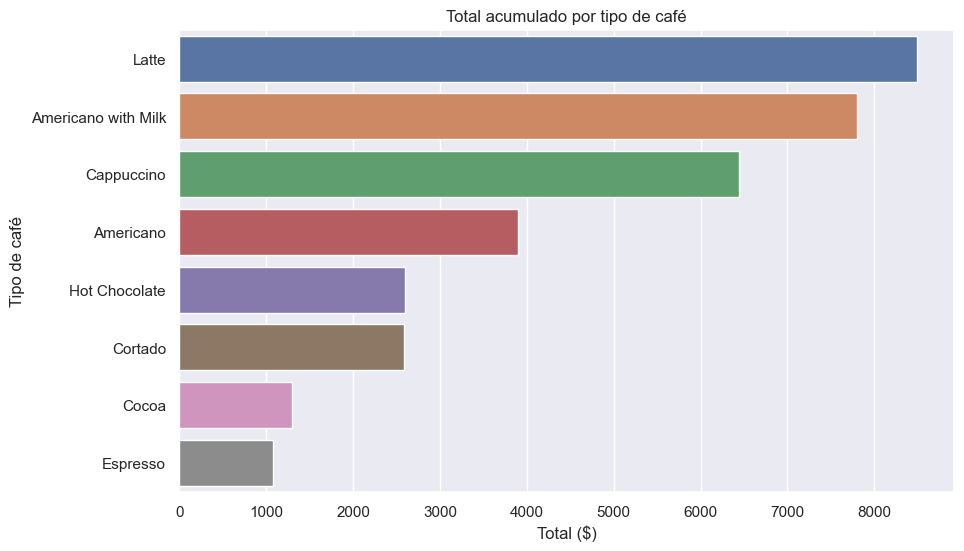

In [149]:
plt.figure(figsize=(10, 6))
# Cuando estamos representando una variable de negocio (money), es preferible usar un barplot
sns.barplot(x='money', y='coffee_name', data=df_coffee_group)

plt.title('Total acumulado por tipo de café')
plt.xlabel('Total ($)')
plt.ylabel('Tipo de café')
plt.show()

In [258]:
def get_occasion(hour):
    if hour < 12:
        return 'morning'
    elif 12 <= hour < 18:
        return 'afternoon'
    else:
        return 'evening'

In [172]:
df_without_duplicates['occasion'] = df_without_duplicates['datetime'].dt.hour.apply(get_occasion)

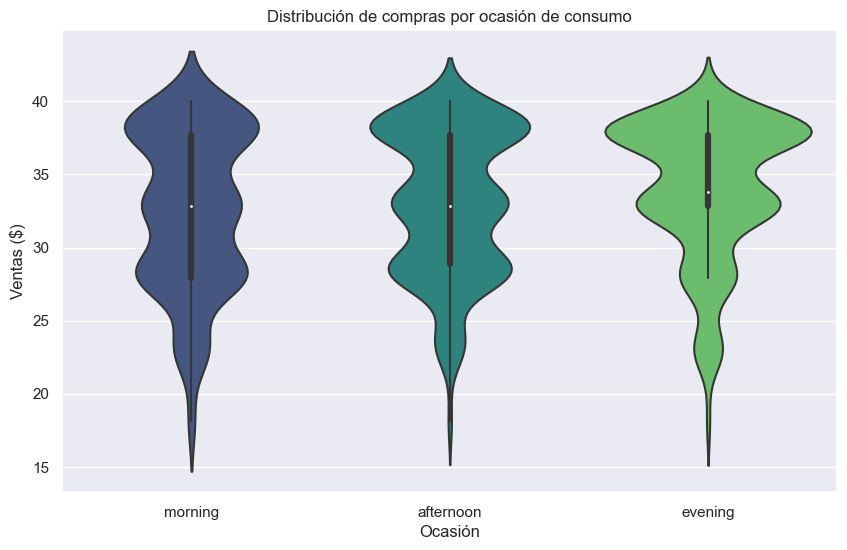

In [178]:
plt.figure(figsize=(10, 6))
sns.violinplot(x='occasion', y='money', data=df_without_duplicates, palette='viridis')

plt.title('Distribución de compras por ocasión de consumo')
plt.xlabel('Ocasión')
plt.ylabel('Ventas ($)')
plt.show()

### Interpretación de resultados

Vemos que no hay mucha diferencia a la hora evaluar el dinero gastado en función de la ocasión de consumo. Lo que si, a tener en cuenta, a la noche el ticket promedio suele ser un poco más alto y hay más variabilidad en los datos. Habiendo algunos outliers de personas que van en horario nocturno y gastán menos.

### Concurrencia de clientes por ocasión

In [252]:
transaction_counts = df_without_duplicates['occasion'].value_counts().reset_index() # el reset_index lo acomoda en el formato de df
transactions_df = pd.DataFrame(transaction_counts)
transactions_df.columns = ['occasion', 'transaction_count']


In [254]:
transactions_df.head()

,occasion,transaction_count
0,afternoon,418
1,morning,318
2,evening,295


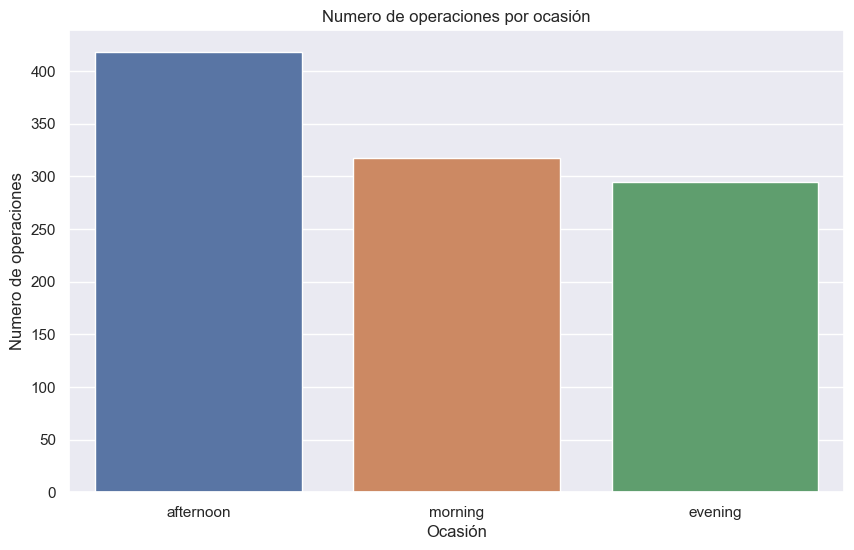

In [259]:
plt.figure(figsize=(10, 6))
sns.barplot(x='occasion', y='transaction_count', data=transactions_df)

plt.xlabel('Ocasión')
plt.ylabel('Numero de operaciones')
plt.title('Numero de operaciones por ocasión')

plt.show()

### Evaluación de Significancia de las muestras

¿Es estadísticamente significativa esta diferencia? Debemos ver esto mismo con una prueba estadística utilizando la prueba de varianza de grupos **ANOVA**

### Fluctuación de la facturación en el mes de Julio agrupado por día

Queremos ver si hay gran variación de la facturación en el período de Julio y para esto debemos agrupar por día.
Para esto se creará una columna que almacene el día de la transacción y otra que almacene el mes.

In [198]:
df_without_duplicates['date'] = pd.to_datetime(df_without_duplicates['date'])
df_without_duplicates['month'] = df_without_duplicates['date'].dt.month
df_without_duplicates['day'] = df_without_duplicates['date'].dt.day

In [203]:
df_july = df_without_duplicates[df_without_duplicates['month'] == 7]

In [204]:
df_july_money_grouped_by_day = df_july.groupby('day')['money'].sum()

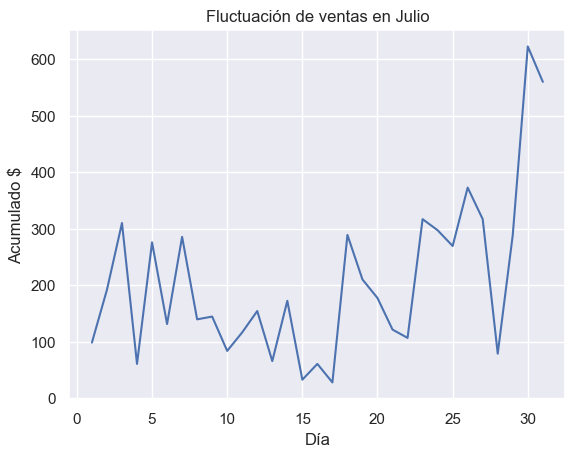

In [244]:
sns.lineplot(data=df_july_money_grouped_by_day)
plt.title('Fluctuación de ventas en Julio')
plt.xlabel('Día')
plt.ylabel('Acumulado $')
plt.show()

### Ingresos por mes

In [299]:
titles = ['March', 'April', 'May', 'June', 'July']

money_march = df_without_duplicates[df_without_duplicates['month']==3]['money'].sum()
money_april = df_without_duplicates[df_without_duplicates['month']==4]['money'].sum()
money_may = df_without_duplicates[df_without_duplicates['month']==5]['money'].sum()
money_june = df_without_duplicates[df_without_duplicates['month']==6]['money'].sum()
money_july = df_without_duplicates[df_without_duplicates['month']==7]['money'].sum()
total_money = [money_march, money_april, money_may, money_june, money_july]

# Datos para los meses y el total de dinero gastado
data = {
    'month': ['March', 'April', 'May', 'June', 'July'],
    'total_money': [money_march, money_april, money_may, money_june, money_july]
}

# Crear el DataFrame
df_money_by_month = pd.DataFrame(data)

In [315]:
money_by_month_mean = df_money_by_month.mean()[0]

/var/folders/dm/31qyb_7s0nqdwc9x5b64b6kdphc6zs/T/ipykernel_76785/2177495974.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  money_by_month_mean = df_money_by_month.mean()[0]


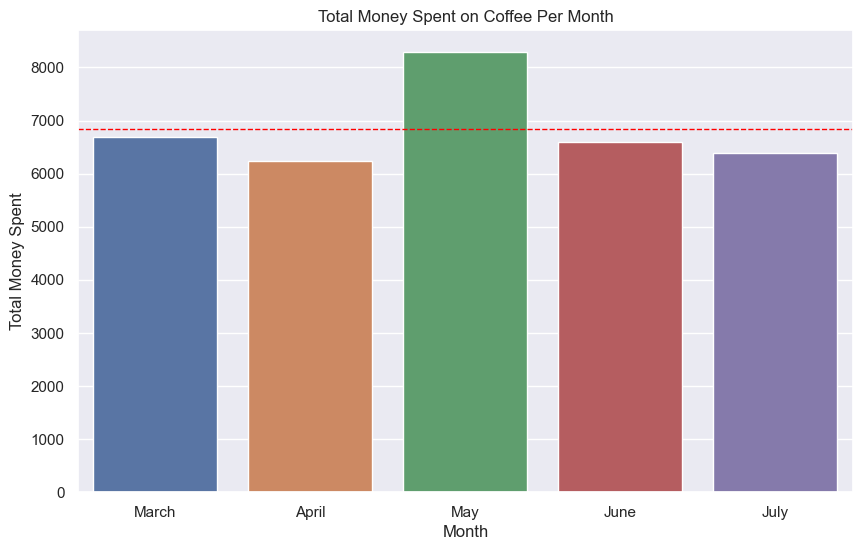

In [316]:
plt.figure(figsize=(10, 6))
sns.barplot(x='month', y='total_money', data=df_money_by_month)
plt.axhline(y=money_by_month_mean, color='red', linestyle='--', linewidth=1)

# Añadir título y etiquetas a los ejes
plt.xlabel('Month')
plt.ylabel('Total Money Spent')
plt.title('Total Money Spent on Coffee Per Month')

# Mostrar el gráfico
plt.show()

### Estimación de clientes únicos

Si bien este dato es bastante aproximado, la relación entre las personas que pagan con efectivo respecto a las que pagan con tarjeta es bastante baja por lo que podría ser una buena aproximación de visitantes únicos que tiene el local.

In [284]:
df_without_duplicates['date'] = df_without_duplicates['datetime'].dt.date
df_without_duplicates['user_id'] = df_without_duplicates['card']

# Agrupar por fecha y contar usuarios únicos
unique_users_per_day = df_without_duplicates.groupby('date')['user_id'].nunique().reset_index()
unique_users_per_day.columns = ['date', 'unique_user_count']

In [288]:
unique_users_per_day_mean = unique_users_per_day.mean()[0]

/var/folders/dm/31qyb_7s0nqdwc9x5b64b6kdphc6zs/T/ipykernel_76785/999685764.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  unique_users_per_day_mean = unique_users_per_day.mean()[0]


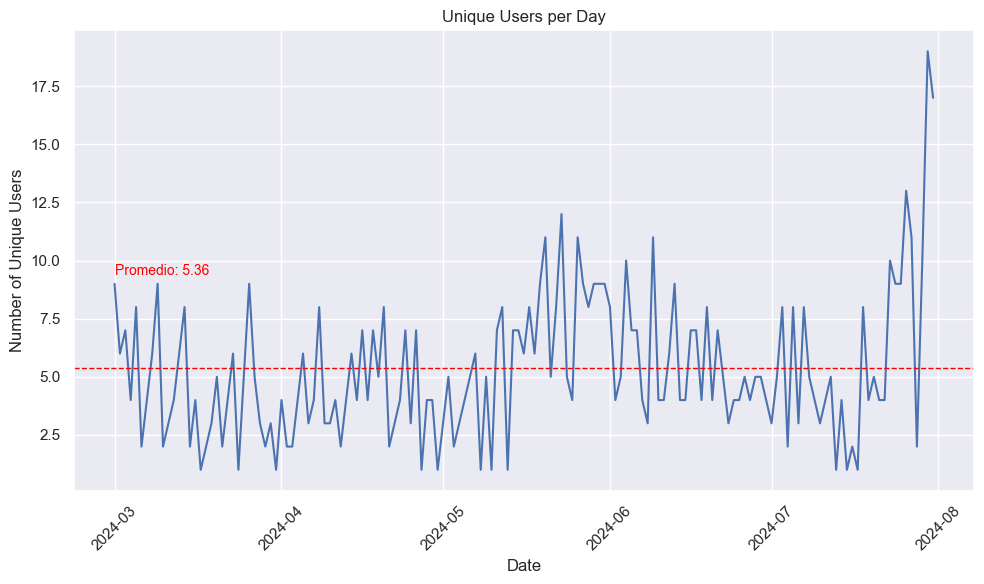

In [298]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=unique_users_per_day, x='date', y='unique_user_count')
plt.axhline(y=unique_users_per_day_mean, color='red', linestyle='--', linewidth=1)

plt.text(unique_users_per_day['date'].min(), unique_users_per_day_mean + 4, 
         f'Promedio: {unique_users_per_day_mean:.2f}', color='red', fontsize=10)

plt.title('Unique Users per Day')
plt.xlabel('Date')
plt.ylabel('Number of Unique Users')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [278]:
unique_users_per_day.mean()

/var/folders/dm/31qyb_7s0nqdwc9x5b64b6kdphc6zs/T/ipykernel_76785/1521146357.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  unique_users_per_day.mean()


unique_user_count    5.36
dtype: float64

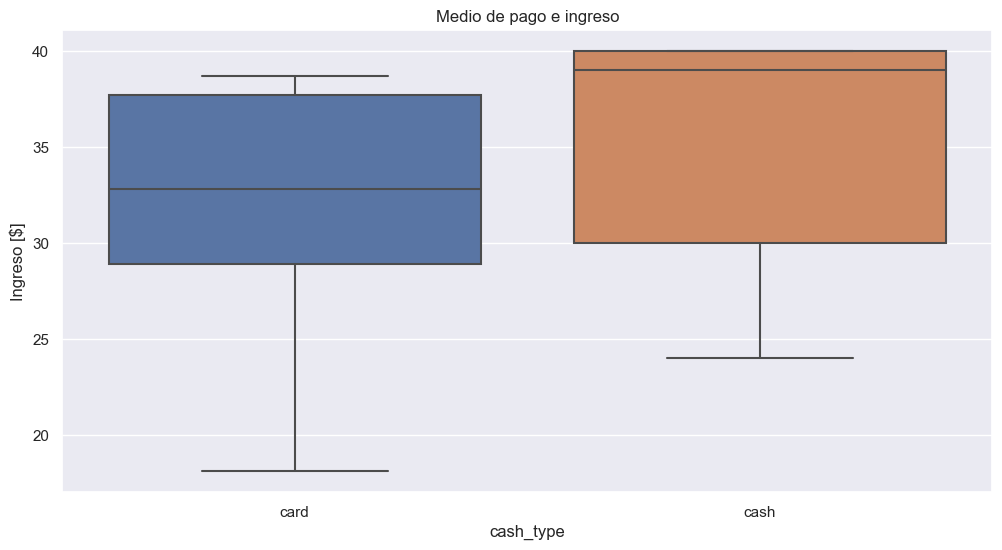

In [274]:
plt.figure(figsize = (12, 6))
sns.boxplot(data=df_without_duplicates, y='money', x='cash_type')
plt.title('Medio de pago e ingreso')
plt.ylabel('Ingreso [$]')
plt.show()

### Sugerencias

Para poder obtener más información y poder sacar conclusiones se proponen recolectar los siguientes features:

- Un listado de los productos más consumidos ya que no debe ser solo café lo que piden los clientes
- Si tuvo algun descuento el cliente
- Si el cliente es habitué del lugar
- Una variable que determine si el pedido fue para llevar o para consumir en el lugar